<a href="https://colab.research.google.com/github/smitc11/ModuleE/blob/main/electricity_price_forecasting_market_trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electricity Price Forecasting and Market Trend Analysis Using Wind SCADA Data

## Selected Project Track
AI for Market Trend Analysis

## Problem Statement
Electricity prices in short-term markets are volatile due to variability in demand
and renewable energy supply. Wind energy introduces uncertainty that directly impacts
price behavior.

The objective is to forecast short-term electricity prices and analyze market trends
driven by wind variability using AI techniques.

## Real-World Motivation
- Market trend monitoring  
- Renewable integration assessment  
- Decision-support for energy planning


# *1. DATA UNDERSTANDING & PREPARATION.*




## Dataset Source

This project uses a combination of:
- **Public wind turbine SCADA data** (real measurements)
- **Synthetic electricity price data** generated using established market principles

Wind data represents a single turbine and is treated as a representative renewable
variability signal. Electricity prices are synthetically generated to enable controlled
market trend analysis due to limited access to continuous market price data.


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [74]:
df = pd.read_csv(
    "wind_scada_with_synthetic_price_FULL.csv",
    parse_dates=["timestamp"]
).sort_values("timestamp").reset_index(drop=True)

df.head()


,timestamp,Wind Speed (m/s),Wind Direction (°),LV ActivePower (kW),Theoretical_Power_Curve (KWh),electricity_price
0,2018-01-01 00:00:00,5.311336,259.994904,380.047791,416.328908,62.849314
1,2018-01-01 00:10:00,5.672167,268.641113,453.769196,519.917511,60.435422
2,2018-01-01 00:20:00,5.216037,272.564789,306.376587,390.900016,63.810847
3,2018-01-01 00:30:00,5.659674,271.258087,419.645905,516.127569,65.654884
4,2018-01-01 00:40:00,5.577941,265.674286,380.650696,491.702972,60.652549


In [75]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   timestamp                      50530 non-null  datetime64[ns]
 1   Wind Speed (m/s)               50530 non-null  float64       
 2   Wind Direction (°)             50530 non-null  float64       
 3   LV ActivePower (kW)            50530 non-null  float64       
 4   Theoretical_Power_Curve (KWh)  50530 non-null  float64       
 5   electricity_price              50530 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 2.3 MB


,timestamp,Wind Speed (m/s),Wind Direction (°),LV ActivePower (kW),Theoretical_Power_Curve (KWh),electricity_price
count,50530,50530.000000,50530.000000,50530.000000,50530.000000,50530.000000
mean,2018-07-01 20:01:30.065307648,7.557952,123.687559,1307.684332,1492.175463,55.952537
min,2018-01-01 00:00:00,0.000000,0.000000,-2.471405,0.000000,28.501622
25%,2018-04-03 05:22:30,4.201395,49.315437,50.677890,161.328167,47.871358
50%,2018-06-30 16:15:00,7.104594,73.712978,825.838074,1063.776283,58.574324
75%,2018-09-26 18:57:30,10.300020,201.696720,2482.507568,2964.972462,63.764513
max,2018-12-31 23:50:00,25.206011,359.997589,3618.732910,3600.000000,78.166438
std,NaN,4.227166,93.443736,1312.459242,1368.018238,9.661581


# *2. DATA QUALITY & MISSING TIMESTAMP HANDLING*



Real-world SCADA data often contains missing timestamps.
Continuous time series are required for lag-based forecasting.


In [76]:
df = df.set_index("timestamp")

expected_range = pd.date_range(
    start=df.index.min(),
    end=df.index.max(),
    freq="10T"
)

missing_ts = expected_range.difference(df.index)
len(missing_ts)


/tmp/ipython-input-2085652937.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  expected_range = pd.date_range(


2030

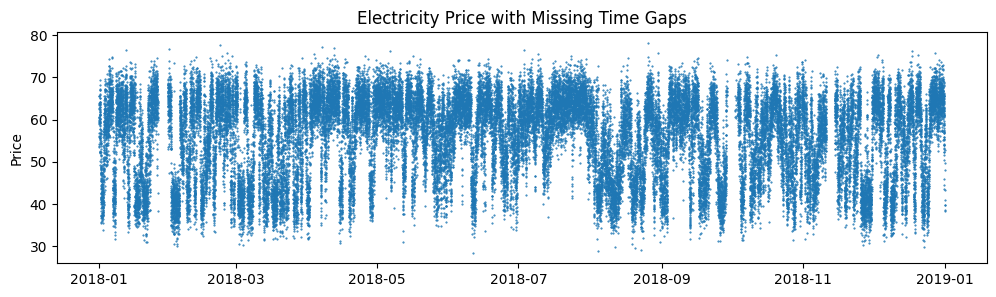

In [77]:
plt.figure(figsize=(12,3))
plt.plot(df.index, df['electricity_price'], marker='.', linestyle='None', markersize=1)
plt.title("Electricity Price with Missing Time Gaps")
plt.ylabel("Price")
plt.show()


In [78]:
df = df.reindex(expected_range)

df['electricity_price'] = df['electricity_price'].interpolate(method='time')
df['LV ActivePower (kW)'] = df['LV ActivePower (kW)'].interpolate(method='time')
df['Wind Speed (m/s)'] = df['Wind Speed (m/s)'].interpolate(method='time')
df['Theoretical_Power_Curve (KWh)'] = df['Theoretical_Power_Curve (KWh)'].interpolate(method='time')
df['Wind Direction (°)'] = df['Wind Direction (°)'].interpolate(method='time')

df.isna().sum()


,0
Wind Speed (m/s),0
Wind Direction (°),0
LV ActivePower (kW),0
Theoretical_Power_Curve (KWh),0
electricity_price,0


In [79]:
df = df.reset_index().rename(columns={'index': 'timestamp'})


In [80]:
#/df = df.set_index("timestamp")

#full_range = pd.date_range(df.index.min(), df.index.max(), freq="10T")
#df = df.reindex(full_range)

#df.interpolate(method="time", inplace=True)
#df.isna().sum()


In [81]:
#df = df.reset_index().rename(columns={"index": "timestamp"})


# *3. EXPLORATORY DATA ANALYSIS (EDA)*









Price time series

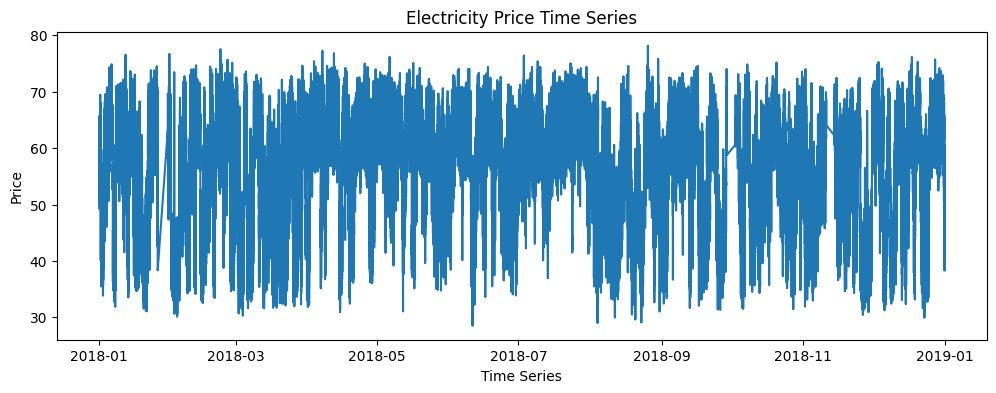

In [82]:
plt.figure(figsize=(12,4))
plt.plot(df["timestamp"], df["electricity_price"])
plt.title("Electricity Price Time Series")
plt.xlabel("Time Series")
plt.ylabel("Price")
plt.show()


Wind power vs electricity price

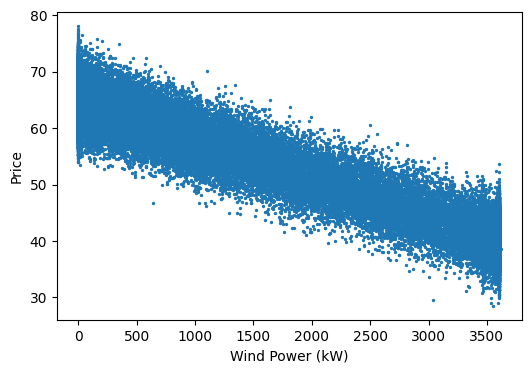

In [83]:
plt.figure(figsize=(6,4))
plt.scatter(df["LV ActivePower (kW)"], df["electricity_price"], s=2)
plt.xlabel("Wind Power (kW)")
plt.ylabel("Price")
plt.show()


Actual vs theoretical power

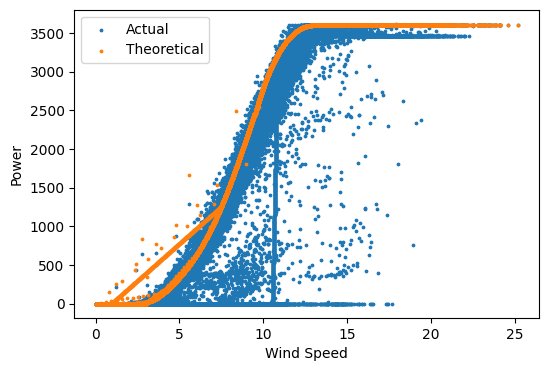

In [84]:
plt.figure(figsize=(6,4))
plt.scatter(df["Wind Speed (m/s)"], df["LV ActivePower (kW)"], s=3, label="Actual")
plt.scatter(df["Wind Speed (m/s)"], df["Theoretical_Power_Curve (KWh)"], s=3, label="Theoretical")
plt.legend()
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.show()


Wind direction vs power

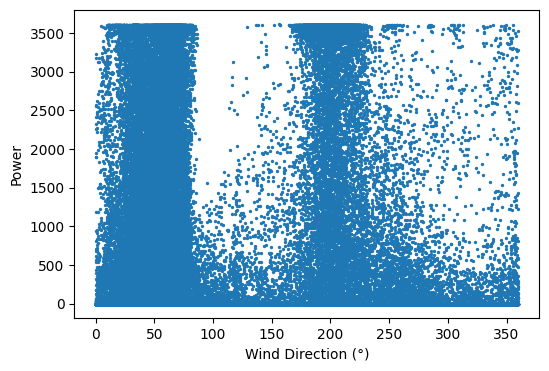

In [85]:
plt.figure(figsize=(6,4))
plt.scatter(df["Wind Direction (°)"], df["LV ActivePower (kW)"], s=2)
plt.xlabel("Wind Direction (°)")
plt.ylabel("Power")
plt.show()


Daily average price trend

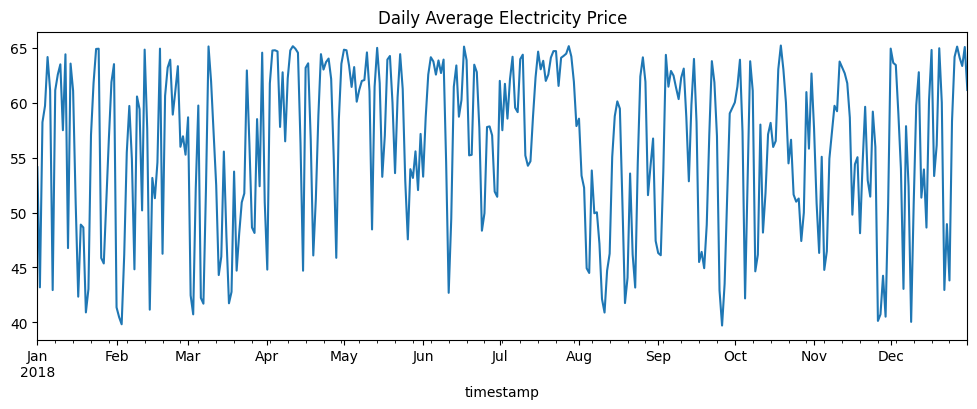

In [86]:
df.set_index("timestamp")["electricity_price"].resample("D").mean().plot(figsize=(12,4))
plt.title("Daily Average Electricity Price")
plt.show()


# *4. Feature Engineering*



Lag-based and rolling features are created to convert the time series
into a supervised learning problem.


In [87]:
df["price_lag1"] = df["electricity_price"].shift(1)
df["price_lag3"] = df["electricity_price"].shift(3)
df["price_roll"] = df["electricity_price"].rolling(6).mean()

df.dropna(inplace=True)


In [88]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 52555 entries, 5 to 52559
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   timestamp                      52555 non-null  datetime64[ns]
 1   Wind Speed (m/s)               52555 non-null  float64       
 2   Wind Direction (°)             52555 non-null  float64       
 3   LV ActivePower (kW)            52555 non-null  float64       
 4   Theoretical_Power_Curve (KWh)  52555 non-null  float64       
 5   electricity_price              52555 non-null  float64       
 6   price_lag1                     52555 non-null  float64       
 7   price_lag3                     52555 non-null  float64       
 8   price_roll                     52555 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 4.0 MB


,timestamp,Wind Speed (m/s),Wind Direction (°),LV ActivePower (kW),Theoretical_Power_Curve (KWh),electricity_price,price_lag1,price_lag3,price_roll
count,52555,52555.000000,52555.000000,52555.000000,52555.000000,52555.000000,52555.000000,52555.000000,52555.000000
mean,2018-07-02 12:20:00,7.487353,121.624397,1277.192314,1480.201256,56.053536,56.053864,56.054374,56.054267
min,2018-01-01 00:50:00,0.000000,0.000000,-2.471405,0.000000,28.501622,28.501622,28.501622,34.719568
25%,2018-04-02 06:35:00,4.073622,47.881420,20.640024,146.539371,48.123140,48.124152,48.124152,48.359952
50%,2018-07-02 12:20:00,7.037702,73.192230,781.281311,1038.410520,58.818088,58.819984,58.820140,59.162615
75%,2018-10-01 18:05:00,10.338660,200.428146,2426.315918,2985.318695,63.690350,63.690350,63.691403,63.619300
max,2018-12-31 23:50:00,25.206011,359.997589,3618.732910,3600.000000,78.166438,78.166438,78.166438,73.748255
std,NaN,4.219846,93.017754,1308.508244,1369.175212,9.582652,9.582514,9.582617,9.055753


# *5. Model Design & Methodology*

### AI Techniques Used
- Baseline statistical forecasting
- Machine learning regression
- Exploratory deep learning (LSTM)

### Rationale
- Baseline establishes reference performance
- Tree-based ML handles non-linear effects
- LSTM explores sequential learning potential


NAÏVE BASELINE

## Trial 1: Naïve Persistence Model

The next electricity price is assumed to be equal to the most recent observed price.


In [89]:
split = int(len(df) * 0.8)

features = [
    "LV ActivePower (kW)",
    "Wind Speed (m/s)",
    "Wind Direction (°)",
    "Theoretical_Power_Curve (KWh)",
    "price_lag1",
    "price_lag3",
    "price_roll"
]

X = df[features]
y = df["electricity_price"]

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

y_pred_naive = y_test.shift(1).bfill()
mean_absolute_error(y_test, y_pred_naive)


3.418243944742262

In [90]:
y_pred_naive = y_test.shift(1).fillna(method='bfill')

mae_naive = mean_absolute_error(y_test, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))

mae_naive, rmse_naive


/tmp/ipython-input-824390202.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_pred_naive = y_test.shift(1).fillna(method='bfill')


(3.418243944742262, np.float64(4.401761528416686))

RANDOM FOREST (MAIN MODEL)

In [99]:
rf = RandomForestRegressor(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mae_rf= mean_absolute_error(y_test, y_pred_rf)


In [100]:
mse_rf=np.sqrt(mean_squared_error(y_test, y_pred_rf))

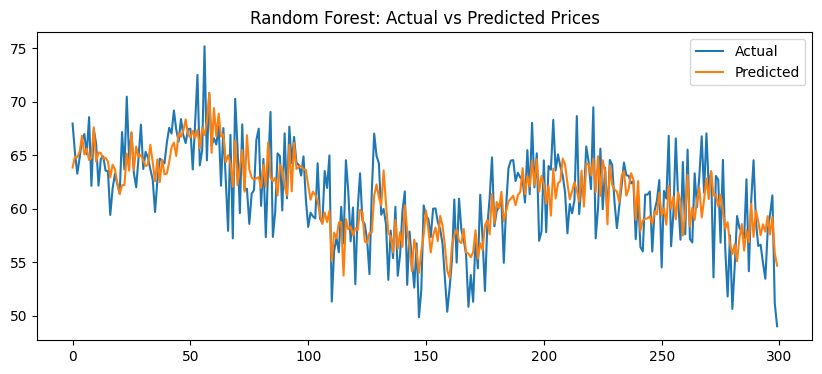

In [101]:
plt.figure(figsize=(10,4))
plt.plot(y_test.values[:300], label="Actual")
plt.plot(y_pred_rf[:300], label="Predicted")
plt.legend()
plt.title("Random Forest: Actual vs Predicted Prices")
plt.show()


LSTM

In [95]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))


In [96]:
def create_sequences(X, y, seq_len=10):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)

split_seq = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_seq], X_seq[split_seq:]
y_train_seq, y_test_seq = y_seq[:split_seq], y_seq[split_seq:]


In [97]:
model_lstm = Sequential([
    LSTM(32, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_seq, y_train_seq, epochs=5, batch_size=64, verbose=0)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [98]:
y_pred_lstm = model_lstm.predict(X_test_seq)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)
y_test_lstm = scaler_y.inverse_transform(y_test_seq)

mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))

mae_lstm, rmse_lstm


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


(2.760288249759998, np.float64(3.5504279477407175))

The Random Forest worked well with the least mean abosulte error 2.23 and least mean squared error 2.89.

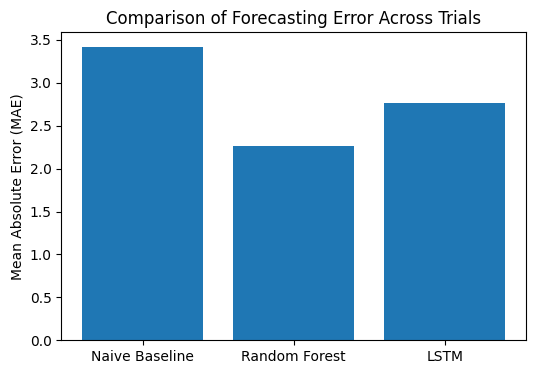

In [102]:
# Collect MAE values from all trials
trial_names = ['Naive Baseline', 'Random Forest', 'LSTM']
mae_values = [mae_naive, mae_rf, mae_lstm]

plt.figure(figsize=(6,4))
plt.bar(trial_names, mae_values)
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Comparison of Forecasting Error Across Trials")
plt.show()


The bar chart compares forecasting accuracy across the three experimental trials.
The naïve baseline establishes a reference error level, while the Random Forest
model shows substantial improvement by learning non-linear relationships.
The LSTM model provides limited additional benefit for this dataset size,
indicating that classical ML models are better suited in this context.


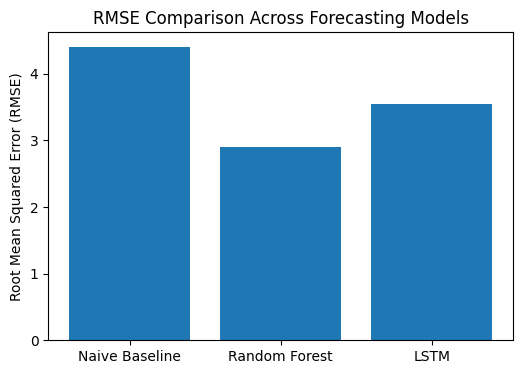

In [104]:
rmse_values = [rmse_naive, mse_rf, rmse_lstm]

plt.figure(figsize=(6,4))
plt.bar(trial_names, rmse_values)
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE Comparison Across Forecasting Models")
plt.show()


# *6. EVALUATION & ANALYSIS*

- Naïve model provides a reference error level
- Random Forest significantly improves accuracy
- LSTM provides limited additional benefit for this dataset



# *7. ETHICAL CONSIDERATIONS & RESPONSIBLE AI*

- Synthetic electricity prices are explicitly declared
- Wind data does not represent full market generation
- Forecasts are not intended for real trading
- Results are for analytical and educational use only




# *9. CONCLUSION & FUTURE SCOPE*

## Conclusion & Future Scope

This project demonstrates a complete AI-driven pipeline
for electricity price forecasting and market trend analysis
using wind SCADA data.

### Future Scope
- Integration of real market price data
- Multi-turbine aggregation
- Longer forecast horizons
- Decision-support dashboards


